In [29]:
import os
import yaml
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from building_energy_storage_simulation import Environment
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.monitor import Monitor
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Define the path to the saved model and logs
logs_path = "logs/ppo/1686340513"

# Load environment configuration from file
environment_config_path = os.path.join("configs", "env.yaml")
with open(environment_config_path, "r") as f:
    environment_config = yaml.safe_load(f)

# Initialize the environment with test dataset
env = Environment(dataset="test.csv", **environment_config)

# Wrap the environment with Monitor for logging and DummyVecEnv for normalization
env = Monitor(env, filename=None)
env = DummyVecEnv([lambda: env])
env = VecNormalize.load(os.path.join(logs_path, "env.pkl"), env)

# Load the trained model
model = PPO.load(os.path.join(logs_path, "model"), env=env)

In [46]:
# Evaluate the model on the test set
env.training = False

# Reset the environment
actions, observations, electricity_consumption, excess_energy, cost_of_external_generator, rewards = ([], [], [], [], [], [])
done = False
obs = env.reset()
while not done:
    action = model.predict(obs, deterministic=True)
    obs, r, done, info = env.step([action[0][0]])
    # Store the results
    actions.append(action[0][0][0])
    original_reward = env.get_original_reward()[0]
    original_obs = env.get_original_obs()[0]
    observations.append(original_obs)
    electricity_consumption.append(info[0]['electricity_consumption'])
    excess_energy.append(info[0]['excess_energy'])
    cost_of_external_generator.append(info[0]['cost_of_external_generator'])
    rewards.append(r)

# Save the results to a CSV file
trajectory = pd.DataFrame({
    'action': actions,
    'observations': observations,
    'electricity_consumption': electricity_consumption,
    'excess_energy': excess_energy,
    'cost_of_external_generator': cost_of_external_generator,
    'reward': rewards
})

trajectory.to_csv(os.path.join(logs_path, "test_results.csv"), index=False)

In [51]:
trajectory['observations'][0]

array([  2.8933966, 101.98     ,  99.8      ,  99.54     , 105.76     ,
       114.38     ,   0.       ,   0.       ,   0.       ,   0.       ,
         1.2      ,  31.       ,  32.       ,  32.       ,  38.78     ,
        47.59     ], dtype=float32)

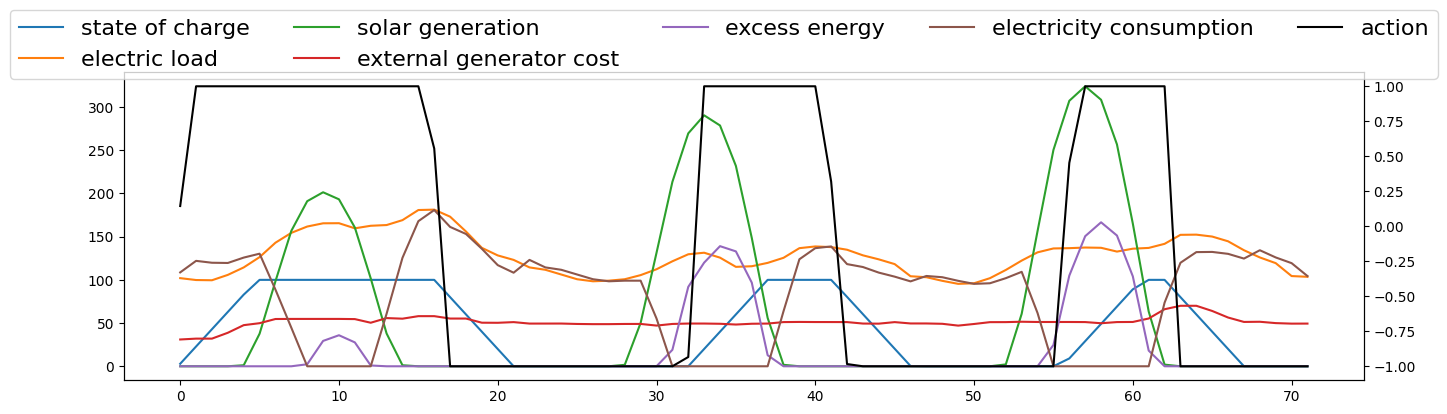

In [52]:
day_number = 0
plot_data = trajectory[day_number * 24 : (day_number + 3) * 24]
observation_df = plot_data['observations'].apply(pd.Series)

plt.rcParams["figure.figsize"] = (16,4)

fig, ax = plt.subplots()
ax.plot(observation_df[0], label = 'state of charge')
ax.plot(observation_df[1], label = 'electric load')
ax.plot(observation_df[6], label = 'solar generation')
ax.plot(observation_df[11], label = 'external generator cost')
ax.plot(plot_data['excess_energy'], label = 'excess energy')
ax.plot(plot_data['electricity_consumption'], label = 'electricity consumption')

ax1 = ax.twinx()
ax1.plot(plot_data['action'], label = 'action', color = 'black')
fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5, prop={'size': 16})

In [53]:
env.training = False

costs = []
done = False
obs = env.reset()
while not done:
    action = model.predict(obs, deterministic=True)
    obs, r, done, info = env.step([action[0][0]])
    costs.append(info[0]['cost_of_external_generator'])

total_costs = sum(costs)
print("Total cost of external generator: ", total_costs)

Total cost of external generator:  9998237.859355915


In [54]:
env.training = False

baseline_costs = []
done = False
obs = env.reset()
while not done:
    # Always taking noop as action. This is the electricity demand if there would be no battery
    action = [0]
    obs, r, done, info = env.step(action)
    baseline_costs.append(info[0]['cost_of_external_generator'])

baseline_total_costs = sum(baseline_costs)
print("Total cost of external generator without battery: ", baseline_total_costs)

Total cost of external generator without battery:  10315285.389200024


In [55]:
money_saved = baseline_total_costs - total_costs
percentage_saved = money_saved / baseline_total_costs * 100
print(f'Money saved: {money_saved:2f} $')
print(f'Percentage saved: {percentage_saved:2f} %')

Money saved: 317047.529844 $
Percentage saved: 3.073570 %
